# Машинное обучение в функциональном стиле

Прежде чем мы передём к основной теме, вспомним, как выглядит типовой сценарий работы с данными и моделями машинного обучения.

## Типовая реализация тренировки ML 

### Генерация данных

Сгенерируем синтетические данные для задачи регрессии. Для этого возьмём пакет **sklearn**.

In [2]:
from sklearn.datasets import make_regression

Подключим пакет для иллюстрация **matplotlib**.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [8,6] # сделаем размер генерируемых картинок побольше

Сгненерируем данные с шумом, которые имеют линейную связь между величинами _x_ и _y_.

In [4]:
seed = 42 
x, y = make_regression(n_samples=1000, n_features=1, noise=4, random_state=seed) # 1000 точек, одномерная величина, std=4
# Приведём к стандартному типу с плавающей одинарной точности
x = x.astype('float32') 
y = y.astype('float32')
# Приведём к стандартной размерности (batch, feature), то есть (1000, 1)
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

Документация по `make_regression`: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html

Проиллюстрируем данные

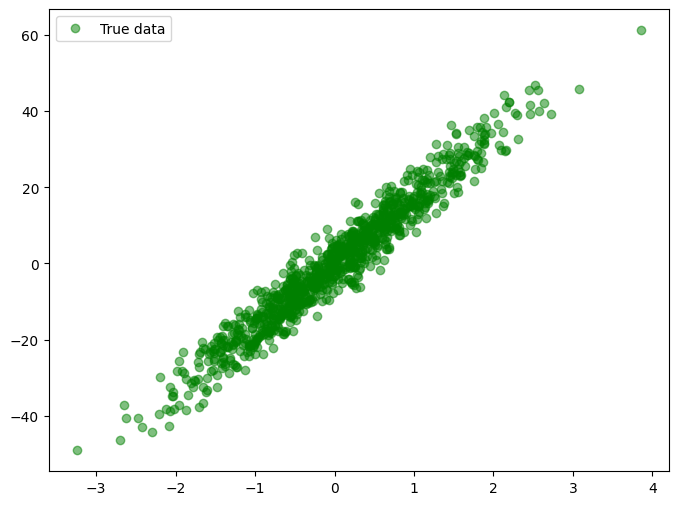

In [5]:
plt.clf()
plt.plot(x, y, 'go', label='True data', alpha=0.5)
plt.legend(loc='best')
plt.show()

### Модель ML

Построим обычную линейную регрессию, используя **pytorch**.

In [40]:
import torch
import torch.nn as nn

Линейная регрессия в матрчной форме задаётся такой формулой:
$$
y = x \cdot \textrm{weights}^T   + \textrm{bias}
$$

это уравнение прямой $y=kx+b$, где размерности матриц следующие.

$$
[n,o]  = [n,i]  \cdot  [i,o] + [o]
$$

$n$ — размер батча (у нас 1000), $o$ — размерность входного тензора (у нас 1), размерность выходного тензора (у нас 1).

In [41]:
x.shape, y.shape

((1000, 1), (1000, 1))

In [56]:
class LinearRegressionModel(nn.Module):
    def __init__(self, features_in, features_hidden):
        super().__init__()
        self.linear = nn.Linear(features_in, features_hidden) # Линейный слой y=xW^T+b
    def forward(self, x):
        return self.linear(x)

Документация по `Linear`: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

In [57]:
model = LinearRegressionModel(1, 1)

Проверим структуру модели

In [58]:
model

LinearRegressionModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

Посмотрим параметры (модель имеет состояние — параметры)

In [59]:
for name,param in model.named_parameters():
    print(f"{name}: {param.data}")

linear.weight: tensor([[0.4518]])
linear.bias: tensor([0.8290])


### Тренировка модели

Мы можем обучать на устройстве, выберем, если есть.
- Apple: Metal Performance Shaders (MPS)
- Nvidia: Compute Unified Device Architecture (CUDA)

In [46]:
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Нашли

In [47]:
device

device(type='mps')

Процедура тренировки:
- Гиперпараметры: learning rate и число эпох
- Loss-функция — MSE (оптимальная loss-функция для задачи регрессии с нормальными данными в задаче MLE)
- Опимизатор — градиентый спуск
- Обучением батчами (не мини-батчами, 1 проход — весь датасет)

Цикл тренировки на каждой эпохе:
- Очищаем градиенты (тензоры хранят значения градиентов, вычисленные ранее)
- Переносим данные на устройство (если надо)
- Выполняем вычисление (forward)
- Вычисляем ошибку (loss) — тензор
- Вычисляем от ошибки градиенты (производную) для всех тензоров, которые требуют изменения (оптимизации, тренировки) методом обратного распространения ошибки (backward)
- Оптимизируем параметры, для которых высчитаны градиенты $w = w_0 + \textrm{lr} \cdot \nabla w$

In [83]:
lr = 0.01 
epochs = 200

model = model.to(device)
model = model.train()

criterion = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

for epoch in range(epochs):
    optimizer.zero_grad()

    inputs = torch.from_numpy(x).to(device)
    labels = torch.from_numpy(y).to(device)
    
    outputs = model(inputs)

    loss = criterion(outputs, labels)
    loss.backward() # средний градиент для всего батча
    optimizer.step()

    if epoch%10 == 0:
        print(f'epoch {epoch}, loss {loss.item()}')

epoch 0, loss 287.1205749511719
epoch 10, loss 199.90133666992188
epoch 20, loss 140.71653747558594
epoch 30, loss 100.55229187011719
epoch 40, loss 73.29385375976562
epoch 50, loss 54.792972564697266
epoch 60, loss 42.23514175415039
epoch 70, loss 33.7106819152832
epoch 80, loss 27.92374038696289
epoch 90, loss 23.99494171142578
epoch 100, loss 21.327468872070312
epoch 110, loss 19.51626968383789
epoch 120, loss 18.286394119262695
epoch 130, loss 17.451210021972656
epoch 140, loss 16.884017944335938
epoch 150, loss 16.498802185058594
epoch 160, loss 16.237159729003906
epoch 170, loss 16.059438705444336
epoch 180, loss 15.938716888427734
epoch 190, loss 15.856707572937012


Посчитаем, что предсказывает модель для _x_

In [84]:
with torch.no_grad(): # переключаем в режим "без градиентов"
    inputs = torch.from_numpy(x).to(device)
    predicted = model(inputs).cpu().data.numpy()

Иллюстрация

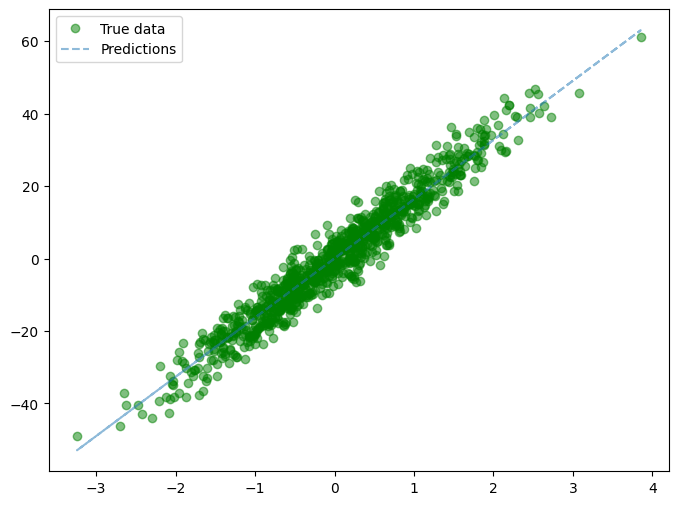

In [85]:
plt.clf()
plt.plot(x, y, 'go', label='True data', alpha=0.5)
plt.plot(x, predicted, '--', label='Predictions', alpha=0.5)
plt.legend(loc='best')
plt.show()

## Функционального программирование

Инженерия — это про управление сложностью. В императивном программировании мы пишем команды, которые изменяют состояние программы. Это источник сложности. Когда программы разрастаются, становится ещё сложнее. Спасает ООП в основном за счёт инкапсуляции (локализация состояния и кода, который его изменяет, в одном объекте). В функциональном подходе предлагается альтернативное решение: минимизировать, а лучше вообще убрать изменение состояния программы. Поэтому, ключевое понятие функционального прогрммирования — immutability.

**Концепции в функциональном стиле (парадигме) программирования:**

- Immutability
- Pure functions (отображают вход в выход, нет побочных эффектов)
    - Referential transparency (значение <-> вызов функции)
    - Anonymous Functions (aka lambda)
- Higher order functions (аргументы — другие фукнкции, functions are first-class objects)
- Lazy Evaluation (not eager evaluation)
- Function composition
- Recursion (вместо циклов)

**Математика:**
- Lambda calculus
- Category theory

**Паттерны:**
- Option type (None-value вместо exceptions)
- Functor (mappable containers: list)
- Monoid (identity + associativity compositon functions: +, concat)
- Monad (functor with flatmap)

### Зачем функциональное программирование в машинном обучении?

- Bug-free: concise, modular, and reusable
- Scale: parallelization
- Fun

**Решает технические проблемы:**
- computing per-sample-gradients (or other per-sample quantities)
- running ensembles of models on a single machine
- efficiently batching together tasks in the inner-loop of MAML
- efficiently computing Jacobians and Hessians
- efficiently computing batched Jacobians and Hessians

# Машинное обучение в функциональном стиле

Мы рассмотрим доминирующую экосистему пакета JAX и функциональное API к популярному фреймворку Pytorch.

## JAX

Документация: https://jax.readthedocs.io/en/latest/index.html

Поддреживает разные backends: CPU, CUDA, TPU. Для поддержки Metal: https://developer.apple.com/metal/jax/

### Что такое JAX?

В области машинного обучения основные вычислительные эксперименты проводят с использованием языка программирования Python. Для работы с многомерными массивы используют библиотеку numpy. В 2018 году Google выпустила библиотеку для Python, которая стала по сути стандартным инструментом их разработок — JAX. Они создали инстурумент, который полностью повторяет API numpy, но работает на разных backendах: CPU, GPU (Nvidia), TPU (Google), MPS (Apple). Они вязли удобноство и добавили к нему скорость через jit-компиляцию (just-in-time). 

JAX — это:
- **JIT-компиляция**
- **Векториязация.** Функциональный стиль API, который упрощает векторизацию вычислений (применении функции к большим данным)
- **Дифференциальное программирование.** Возможность вычисляеть производные, что необходимо для градиентных методов оптимизации


Кто использует?

Google (Google Brain, DeepMind)

### JAX API ≅ Numpy API

Код, написанный на numpy можно переиспользовать, подменив на вызов jax

In [1]:
import numpy as np
import jax.numpy as jnp

#### NumPy

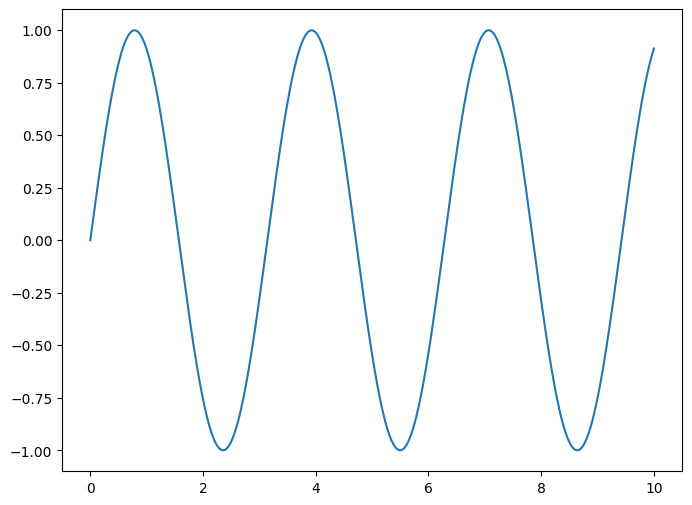

In [77]:
x = np.linspace(0, 10, 1000)
y = 2 * np.sin(x) * np.cos(x)
plt.plot(x, y);

In [78]:
type(x), type(y)

(numpy.ndarray, numpy.ndarray)

#### JAX

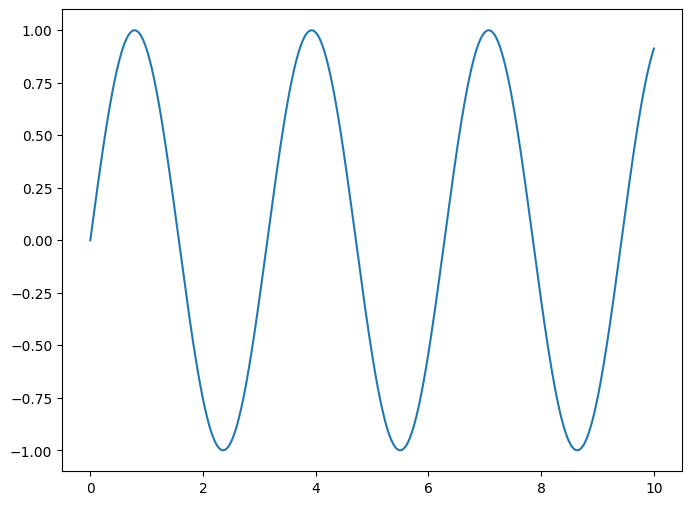

In [119]:
x = jnp.linspace(0, 10, 1000)
y = 2 * jnp.sin(x) * jnp.cos(x)
plt.plot(x, y);

In [120]:
type(x), type(y)

(jaxlib.xla_extension.ArrayImpl, jaxlib.xla_extension.ArrayImpl)

### Особенность: Immutable Arrays

В отличии от numpy в jax неизменяемые массивы

In [35]:
a = np.zeros(10)
print("   до", a)
a[0]=1
print("после", a)

   до [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
после [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [37]:
a = jnp.zeros(10)
print("   до", a)
a[0]=1 # должна быть ошибка
print("после", a)

   до [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


TypeError: '<class 'jaxlib.xla_extension.ArrayImpl'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

В парадигме jax, если надо изменить значение, то мы его копируем

In [54]:
a = jnp.zeros(10)
print("   до", a)
b = a.at[0].set(1) # in jit is in-place
print("после", a)
print("после", b, "(копия)")

   до [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
после [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
после [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] (копия)


### Генерация случайных чисел

#### NumPy

In [122]:
import numpy as np

seed = 42
np.random.seed(seed)

In [130]:
full_random_state = np.random.get_state()
print(str(full_random_state)[:460])

('MT19937', array([        42, 3107752595, 1895908407, 3900362577, 3030691166,
       4081230161, 2732361568, 1361238961, 3961642104,  867618704,
       2837705690, 3281374275, 3928479052, 3691474744, 3088217429,
       1769265762, 3769508895, 2731227933, 2930436685,  486258750,
       1452990090, 3321835500, 3520974945, 2343938241,  928051207,
       2811458012, 3391994544, 3688461242, 1372039449, 3706424981,
       1717012300, 1728812672, 1688496645, 120


In [131]:
np.random.uniform()

0.3745401188473625

In [133]:
full_random_state = np.random.get_state()
print(str(full_random_state)[:460])

('MT19937', array([ 723970371, 1229153189, 4170412009, 2042542564, 3342822751,
       3177601514, 1210243767, 2648089330, 1412570585, 3849763494,
       2465546753, 1778048360, 3414291523, 3703604926,   37084547,
       2893685227, 1573484469, 1285239205,  699098282, 4130757601,
        396734834, 4180643673, 4141803214, 1198799333,  762411010,
        293648282, 3223568971, 2632094559,  537008479,  741113140,
       4002027498, 2746025092, 2845827535,  54


#### JAX

- reproducible
- parallelizable
- vectorisable

Threefry counter-based PRNG

In [137]:
from jax import random

seed = 42
key = random.PRNGKey(seed) 

print(key)

[42 42]


In [140]:
print(random.normal(key))
print(random.normal(key))

-0.9350606
-0.9350606


In [144]:
new_key, subkey = random.split(key)
print("new key:", new_key)
print("subkey:", subkey)

new key: [1740183447 2549240159]
subkey: [355035417 137792341]


In [145]:
print(random.normal(new_key))

0.8927178


### JIT в JAX: backends через XLA

In [11]:
from jax import jit

#### Пример с norm

Давайте объявим функцию и скомпилируем её с помощью jit-компилятора. Нормализация массива (делаем среднее 0 и дисперсию 1)

In [146]:
# Функция нормализации
def norm(x):
  x = x - x.mean(0)
  return x / x.std(0)

In [147]:
from jax import random
key = random.PRNGKey(0)
x = random.normal(key, (10000, 1000))

JAX исползует lazy-вычисления (возвращает future, надо вызывать block_until_ready, чтобы дождаться результата)

In [151]:
%timeit norm(x).block_until_ready()

4.9 ms ± 274 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [153]:
from jax import jit
norm_compiled = jit(norm)

In [154]:
norm_compiled(x).block_until_ready()
%timeit norm_compiled(x).block_until_ready()

1.58 ms ± 69.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [155]:
norm_compiled_cpu = jit(norm, backend='cpu')
norm_compiled_cpu(x).block_until_ready()
%timeit norm_compiled_cpu(x).block_until_ready()

13.7 ms ± 146 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [170]:
from jax import make_jaxpr
make_jaxpr(norm)(x)

{ lambda ; a:f32[1024,1024]. let
    b:f32[1024] = reduce_sum[axes=(0,)] a
    c:f32[1024] = div b 1024.0
    d:f32[1,1024] = broadcast_in_dim[broadcast_dimensions=(1,) shape=(1, 1024)] c
    e:f32[1024,1024] = sub a d
    f:f32[1024] = pjit[
      jaxpr={ lambda ; g:f32[1024,1024] h:i32[]. let
          i:f32[1024] = pjit[
            jaxpr={ lambda ; j:f32[1024,1024] k:i32[]. let
                l:f32[1024] = reduce_sum[axes=(0,)] j
                m:f32[1,1024] = broadcast_in_dim[
                  broadcast_dimensions=(1,)
                  shape=(1, 1024)
                ] l
                n:f32[1,1024] = div m 1024.0
                o:f32[1024,1024] = sub j n
                p:f32[1024,1024] = integer_pow[y=2] o
                q:f32[] = convert_element_type[
                  new_dtype=float32
                  weak_type=False
                ] k
                r:f32[] = sub 1024.0 q
                s:f32[1024] = reduce_sum[axes=(0,)] p
                t:f32[1024] = div s r
  

#### Пример с matmul

In [167]:
def matmul(x, y):
  return x@y

In [161]:
from jax import random
key = random.PRNGKey(0)
x = random.normal(key, (1024, 1024))
key, _ = random.split(key)
y = random.normal(key, (1024, 1024))

In [162]:
%timeit matmul(x,y).block_until_ready()

835 µs ± 33.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [163]:
from jax import jit
matmul_compiled = jit(matmul)

In [164]:
matmul_compiled(x,y).block_until_ready()
%timeit matmul_compiled(x,y).block_until_ready()

827 µs ± 6.99 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [165]:
matmul_compiled_cpu = jit(matmux, backend='cpu')
matmul_compiled_cpu(x,y).block_until_ready()
%timeit matmul_compiled_cpu(x,y).block_until_ready()

5.15 ms ± 58.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [168]:
from jax import make_jaxpr
make_jaxpr(matmul)(x,y)

{ lambda ; a:f32[1024,1024] b:f32[1024,1024]. let
    c:f32[1024,1024] = dot_general[dimension_numbers=(([1], [0]), ([], []))] a b
  in (c,) }

### Векторизация и распаралливание на несколько устройств

Неявное распараллеливание через XLA

In [171]:
def convolve(x, w):
  output = []
  for i in range(1, len(x)-1):
    output.append(jnp.dot(x[i-1:i+2], w))
  return jnp.array(output)

In [173]:
x = jnp.arange(5)
w = jnp.array([2., 3., 4.])
convolve(x, w)

Array([11., 20., 29.], dtype=float32)

In [177]:
from jax import vmap

xs = jnp.stack([x, x])
ws = jnp.stack([w, w])

auto_batch_convolve = vmap(convolve)
auto_batch_convolve(xs, ws)

Array([[11., 20., 29.],
       [11., 20., 29.]], dtype=float32)

Можно настроить in_axes, out_axes

#### VMAP -> PMAP

In [201]:
from jax import pmap, local_device_count,devices

In [182]:
local_device_count() 

1

In [202]:
devices()

[MetalDevice(id=0, process_index=0)]

Если устройств больше 1, то можно вызвать pmap

In [184]:
auto_batch_convolve = pmap(convolve)
# auto_batch_convolve(xs, ws) 

### Дифференцирование

В отличие от других библиотек дифференцирование применяется к функции, а не к массиву (тензору)

In [2]:
from jax import grad

#### Склярные функции одного аргумента

Скалярная функция скалярного аргумента

In [3]:
f = lambda x: x**3 + 2*x**2 - 3*x + 1

Первая производная

In [4]:
# 3x**2 + 4x - 3
dfdx = grad(f)

In [5]:
x = jnp.array(1.)
f(x), dfdx(x)

Metal device set to: Apple M1 Pro


(Array(1., dtype=float32, weak_type=True),
 Array(4., dtype=float32, weak_type=True))

Вторая производная

In [6]:
# 6x+4
dfdxdx = grad(dfdx)
dfdxdx(1.)

Array(10., dtype=float32, weak_type=True)

#### Склярные функции нескольких аргумента

- Первая производная — вектор
- Вторая производная — матрица (Hessian)

In [14]:
from jax import jacfwd, jacrev
xvec = jnp.array([1.0,2.0,3.0])
f = lambda x: jnp.dot(x, x)
xvec, f(xvec)

(Array([1., 2., 3.], dtype=float32), Array(14., dtype=float32))

In [15]:
grad(f)(xvec) # ok

Array([2., 4., 6.], dtype=float32)

In [16]:
grad(grad(f))(xvec) # должна быть ошибка

TypeError: Gradient only defined for scalar-output functions. Output had shape: (3,).

In [1]:
hessian = jit(jacfwd(jacrev(f)))

NameError: name 'jit' is not defined

In [ ]:
hessian(xvec)

### Экосистема 

JAX обладает разнообразной архитектурой, ниже приведены некоторые примеры пакетов, базирующиеся на JAX
- Flax: Google, пакет для моделирования нейронных сетей, https://flax.readthedocs.io/en/latest/getting_started.html
- Haiku: DeepMind, пакет для моделирования нейронных сейтей, https://dm-haiku.readthedocs.io/en/latest/
- Eqinox: Patrick Kidger, Google X, пакет для моделирования нейронных сейтей, https://docs.kidger.site/equinox/
- Optax: DeepMind, пакет градиентных оптимизационных методов, https://optax.readthedocs.io/en/latest/
- RLax: DeepMind, пакет для reinforcement learning'а, https://rlax.readthedocs.io/en/latest/
- Chex: DeepMind, пакет для тестирования, https://chex.readthedocs.io/en/latest/
- Jraph: DeepMind, пакет для графовых нейронных сейтей, https://jraph.readthedocs.io/en/latest/

#### Flax

Документация: https://flax.readthedocs.io/en/latest/getting_started.html

In [6]:
import jax
from typing import Any, Callable, Sequence
from jax import lax, random, numpy as jnp
from flax.core import freeze, unfreeze
from flax import linen as nn

model = nn.Dense(features=1)

seed=42
key = random.PRNGKey(seed)
params = model.init(key, x) # Initialization call
jax.tree_util.tree_map(lambda x: x.shape, params) # Checking output shapes


@jax.jit
def mse(params, x_batched, y_batched):
  def squared_error(x, y):
    pred = model.apply(params, x)
    return jnp.inner(y-pred, y-pred) / 2.0
  return jnp.mean(jax.vmap(squared_error)(x_batched,y_batched), axis=0)


@jax.jit
def update_params(params, learning_rate, grads):
  params = jax.tree_util.tree_map(
      lambda p, g: p - learning_rate * g, params, grads)
  return params

model.apply(params, x)

Array([[ 2.78478932e+00],
       [-1.63382328e+00],
       [ 7.72076070e-01],
       [-2.95231879e-01],
       [-1.14917934e+00],
       [-1.53994346e+00],
       [-1.02188873e+00],
       [-1.07970750e+00],
       [ 2.26448679e+00],
       [-1.68897355e+00],
       [-2.45506358e+00],
       [ 2.46499434e-01],
       [ 4.27320153e-01],
       [ 3.64486361e+00],
       [ 2.95662904e+00],
       [ 1.17857948e-01],
       [-9.31541920e-01],
       [-1.91038716e+00],
       [ 3.04584503e-01],
       [-1.77273571e+00],
       [ 4.90136057e-01],
       [ 2.02723503e+00],
       [-2.06973076e+00],
       [-1.86752641e+00],
       [-1.37106344e-01],
       [-7.50267386e-01],
       [-6.80257797e-01],
       [-7.74875998e-01],
       [ 2.22857928e+00],
       [ 7.97203720e-01],
       [ 8.74390364e-01],
       [ 1.30190432e+00],
       [-2.45416713e+00],
       [-9.12920713e-01],
       [-3.67428035e-01],
       [-5.35975456e-01],
       [ 5.95908165e-02],
       [ 1.29175460e+00],
       [ 2.2

GPT2 Flax in transformers: https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_flax_gpt2.py#L380

## Pytorch Func (ex-functorch)

JAX-like API библиотека

Документация: https://pytorch.org/docs/stable/func.html

#### Основные элементы API

- `grad(f)` gradient computation
- `vmap(f)` auto-vectorization

In [55]:
import torch

In [62]:
model = LinearRegressionModel(1,1)
model

LinearRegressionModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

In [64]:
params = dict(model.named_parameters())
params

{'linear.weight': Parameter containing:
 tensor([[-0.1124]], requires_grad=True),
 'linear.bias': Parameter containing:
 tensor([-0.4330], requires_grad=True)}

In [67]:
from torch.func import functional_call
inputs = torch.from_numpy(x)
out = functional_call(model, params, (inputs,))

In [70]:
from torch.func import grad
grad_fn = grad(model) # возвращает функцию, преобразующую model (как функцию), аргументы те же

### Per-sample gradients 

#### Традиционный подход

In [92]:
lr = 0.01 
epochs = 200

model = model.to(device)
model = model.train()

criterion = torch.nn.MSELoss() 

def compute_grad(sample, target):
    sample = sample.unsqueeze(0) 
    target = target.unsqueeze(0)

    prediction = model(sample)
    loss = criterion(prediction, target)

    return torch.autograd.grad(loss, list(model.parameters()))


def compute_sample_grads(data, targets):
    batch_size = data.shape[0]
    sample_grads = [compute_grad(data[i], targets[i]) for i in range(batch_size)]
    sample_grads = zip(*sample_grads)
    sample_grads = [torch.stack(shards) for shards in sample_grads]
    return sample_grads


In [108]:
inputs = torch.from_numpy(x).to(device)
labels = torch.from_numpy(y).to(device)
per_sample_grads = compute_sample_grads(inputs, labels)

In [94]:
len(per_sample_grads)

2

In [96]:
per_sample_grads[0].shape # weight

torch.Size([1000, 1, 1])

In [97]:
per_sample_grads[1].shape # bias

torch.Size([1000, 1])

#### Функциональный подход

In [105]:
from torch.func import functional_call, vmap, grad

In [106]:
lr = 0.01 
epochs = 200

model = model.to(device)
model = model.train()

criterion = torch.nn.MSELoss() 

params = {k: v.detach() for k, v in model.named_parameters()}


def compute_loss(params, sample, target):
    batch = sample.unsqueeze(0)
    targets = target.unsqueeze(0)

    predictions = functional_call(model, (params,), (batch,))
    loss = criterion(predictions, targets)
    return loss


ft_compute_grad = grad(compute_loss)

ft_compute_sample_grad = vmap(ft_compute_grad, in_dims=(None, 0, 0))

In [109]:
inputs = torch.from_numpy(x).to(device)
labels = torch.from_numpy(y).to(device)
ft_per_sample_grads = ft_compute_sample_grad(params, inputs, labels)

In [112]:
ft_per_sample_grads['linear.weight'].shape

torch.Size([1000, 1, 1])

In [114]:
for per_sample_grad, ft_per_sample_grad in zip(per_sample_grads, ft_per_sample_grads.values()):
    assert torch.allclose(per_sample_grad, ft_per_sample_grad, atol=3e-3, rtol=1e-5)

#### Сравнение производительности

In [118]:
%timeit compute_sample_grads(inputs, labels)

313 ms ± 1.73 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [117]:
%timeit ft_compute_sample_grad(params, inputs, labels)

750 µs ± 21.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
